In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time
import sys
import pytorch_model_summary
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


print(f'torch : {torch.__version__}')
print(f'python : {sys.version}')

torch : 1.11.0
python : 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]


In [2]:

class ImageData(Dataset):
    def __init__(self,path,transform=None,target_transform=None):
        self.path = path
        self.files =[]
        self.labels = []
        for i in os.listdir(path):
            if i[:-3]+'png' in os.listdir(path+'/label'):
                self.files.append(i)
                self.labels.append(i[:-3]+'png')
        self.transform = transform
        self.target_transform = target_transform
        self.to_tensor = transforms.ToTensor()
        
    def __getitem__(self,idx):
        img = Image.open(self.path+'/'+self.files[idx])
        label = Image.open(self.path+'/label/'+self.labels[idx])
        #img = np.array(img)[:,:256]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            label = self.target_transform(label)
        return img, label

    def __len__(self):
        return len(self.files)

class ConvertToBackground(object):
    def __call__(self, img):
        img = np.asarray(img,dtype=np.uint8)
        img[img==255] = 0
        # 64bit 부호 정수 long 타입 Tensor로 변환 
        img = torch.from_numpy(img).long()
        return img


In [3]:
data_mean = [0.485, 0.456, 0.406]
data_std = [0.229, 0.224, 0.225]

transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        #transforms.RandomCrop((224,224)),
        #transforms.RandomAffine(degrees=15),
        # PIL 타입의 [0,255] data를 [0,1]의 FloatTensor로 변환
        transforms.ToTensor(),
        transforms.Normalize(mean=data_mean,std=data_std)
    ]
)
val_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=data_mean,std=data_std)
    ]
)
label_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        # 경계를 배경으로 처리
        ConvertToBackground()
    ]
)

batch_size = 4
train_path = './data/train'
train_set = ImageData(train_path,transform,label_transform)
#train_set = torchvision.datasets.VOCSegmentation(root='./data', year='2012',\
#    image_set='train',download=False,transform=transform,target_transform=label_transform)
train_loader = DataLoader(train_set, batch_size= batch_size,shuffle=True)
val_path = './data/val'
val_set = ImageData(val_path,val_transform,label_transform)
#val_set = torchvision.datasets.VOCSegmentation(root='./data', year='2012',\
#    image_set='val',download=False,transform=transform,target_transform=label_transform)
val_loader = DataLoader(val_set, batch_size= batch_size,shuffle=True)


In [4]:
#a,b = train_set[0]
#print(a.shape)

print(len(train_loader))
#temp_img,temp_label = next(iter(train_loader))
#print(temp_img)

366


In [5]:
# 사전에 학습된 vgg16 parameter 가져오기
vgg19 = torchvision.models.vgg19(pretrained=True)
for param in vgg19.features.parameters():
   param.requires_grad = False
print(vgg19.features[:-9])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [6]:
class FCN8(nn.Module):
    # vgg 19 
    def __init__(self,num_class):
        super(FCN8, self).__init__()
        self.vgg19 = vgg19.features

        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, num_class, kernel_size=1)
    def forward(self, x):
        pool3 = self.vgg19[:-18](x)
        pool4 = self.vgg19[-18:-9](pool3)
        pool5 = self.vgg19[-9:](pool4)

        x = self.relu(self.deconv1(pool5))
        x = self.bn1(x+pool4)
        x = self.relu(self.deconv2(x))
        x = self.bn2(x+pool3)
        x = self.relu(self.deconv3(x))
        x = self.bn3(x)
        x = self.relu(self.deconv4(x))
        x = self.bn4(x)
        x = self.relu(self.deconv5(x))
        x = self.bn5(x)
        x = self.classifier(x)
        #print(x.shape)
        return x

    def make_block(self, in_channel, out_channel, repeat):
        layers = []
        for i in range(repeat):
            if (i==0):
                layers.append(nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, stride=1))
            else:
                layers.append(nn.Conv2d(out_channel,out_channel,kernel_size=3, padding=1, stride=1))
            layers.append(nn.BatchNorm2d(out_channel))
            layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        block = nn.Sequential(*layers)

        return block

In [7]:
FCN =FCN8(num_class=21)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
#print(FCN)
print(pytorch_model_summary.summary(FCN,torch.zeros(batch_size,3,224,224),show_input=True))

Using cuda device
-----------------------------------------------------------------------------
         Layer (type)            Input Shape         Param #     Tr. Param #
             Conv2d-1       [4, 3, 224, 224]           1,792               0
               ReLU-2      [4, 64, 224, 224]               0               0
             Conv2d-3      [4, 64, 224, 224]          36,928               0
               ReLU-4      [4, 64, 224, 224]               0               0
          MaxPool2d-5      [4, 64, 224, 224]               0               0
             Conv2d-6      [4, 64, 112, 112]          73,856               0
               ReLU-7     [4, 128, 112, 112]               0               0
             Conv2d-8     [4, 128, 112, 112]         147,584               0
               ReLU-9     [4, 128, 112, 112]               0               0
         MaxPool2d-10     [4, 128, 112, 112]               0               0
            Conv2d-11       [4, 128, 56, 56]         295,

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(FCN.parameters(), lr=0.0001)

In [9]:
def pixel_accuracy(output, label):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1),dim=1)
        correct = torch.eq(output, label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy
# https://sanghyu.tistory.com/3 -- view, contiguous
def mIoU(output, label,num_classes=21):
    with torch.no_grad():
        output = F.softmax(output, dim=1)
        output = torch.argmax(output, dim=1)
        # 메모리에 저장된 순서를 하나씩, view할때 섞이지 않도록
        output = output.contiguous().view(-1)
        label = label.contiguous().view(-1)
    
        iou_class = []
        for c in range(0, num_classes):
            output_true = output==c
            label_true = label==c

            if label_true.long().sum().item() == 0:
                iou_class.append(np.nan)
            else:
                intersect = torch.logical_and(output_true,label_true).sum().float().item()
                union = torch.logical_or(output_true,label_true).sum().float().item()
                iou= intersect/union
                iou_class.append(iou)
        return np.nanmean(iou_class)

def get_lr(optim):
    for param_group in optim.param_groups:
        return param_group['lr']

In [10]:
# 학습
FCN.to(device)
epochs= 100
best_loss = 0
train_loss_list = []
train_acc_list = []
train_iou_list = []
val_loss_list = []
val_acc_list = []
val_iou_list = []
min_loss = np.inf
stop_count = 0
lrs = []
for epoch in range(epochs):
    val_running_loss = 0
    train_running_loss =0
    start_time = time.time()
    train_iou_score = 0
    val_iou_score =0
    train_acc = 0
    val_acc = 0

    FCN.train()
    for iter,data in tqdm(enumerate(train_loader)):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = FCN(inputs)
        # print(f'input shape : {inputs.shape}')
        # print(f'output shape : {outputs[0][0].shape}')
        # print(f'output  --{outputs[0][0]}')
        # print(f'labels shape : {labels.shape}')
        # print(f'lable --{labels[labels>0]}')
        loss = criterion(outputs,labels) 
        loss.backward()
        optimizer.step()

        train_iou_score += mIoU(outputs, labels)
        train_acc += pixel_accuracy(outputs, labels)
        train_running_loss += loss.item()
    
    FCN.eval()
    with torch.no_grad():
        for iter, vdata in tqdm(enumerate(val_loader)):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)

            voutputs = FCN(vinputs)
            vloss = criterion(voutputs,vlabels)

            val_running_loss += vloss.item()
            val_iou_score += mIoU(voutputs,vlabels)
            val_acc += pixel_accuracy(voutputs,vlabels)


        train_running_loss /= len(train_loader)
        train_iou_score /=len(train_loader)
        train_acc /=len(train_loader)
        val_running_loss /= len(val_loader)
        val_iou_score /=len(val_loader)
        val_acc /=len(val_loader)
        lrs.append(get_lr(optimizer))

        print(f'{epoch+1} epcoh , time = {time.time()-start_time:.2f}')
        print(f'train loss : {train_running_loss:.5f}, val_loss : {val_running_loss:.5f}')
        print(f'train IoU : {train_iou_score:.5f}, val IoU : {val_iou_score:.5f}')
        print(f'train Acc : {train_acc:.5f}, val Acc : {val_acc:.5f}')
        train_loss_list.append(train_running_loss)
        train_iou_list.append(train_iou_score)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_running_loss)
        val_iou_list.append(val_iou_score)
        val_acc_list.append(val_acc)

        if min_loss < val_running_loss:
            #min_loss = val_running_loss
            stop_count +=1
            if stop_count == 5:
                print('Stop loss not decrease')

                break
        elif min_loss > val_running_loss:
            min_loss = val_running_loss
            stop_count = 0
            #print('save model')
            torch.save(FCN, './models/FCN8-Vgg19.pt') 
            
                   
history = {'train_loss': train_loss_list, 'val_loss':val_loss_list,'train_miou': train_iou_list,
'val_miou':val_iou_list,'train_acc':train_acc_list,'val_acc':val_acc_list, 'lr':lrs}
print('Finish Training')

366it [00:23, 15.64it/s]
363it [00:20, 17.50it/s]


1 epcoh , time = 44.15
train loss : 2.49517, val_loss : 2.00242
train IoU : 0.13681, val IoU : 0.17558
train Acc : 0.53411, val Acc : 0.69593


366it [00:21, 17.38it/s]
363it [00:20, 17.90it/s]


2 epcoh , time = 41.35
train loss : 1.81382, val_loss : 1.51936
train IoU : 0.19727, val IoU : 0.21932
train Acc : 0.72847, val Acc : 0.76684


366it [00:20, 17.60it/s]
363it [00:20, 18.05it/s]


3 epcoh , time = 40.92
train loss : 1.48080, val_loss : 1.30680
train IoU : 0.21823, val IoU : 0.23867
train Acc : 0.76233, val Acc : 0.78390


366it [00:21, 17.24it/s]
363it [00:20, 18.07it/s]


4 epcoh , time = 41.32
train loss : 1.29651, val_loss : 1.06448
train IoU : 0.22776, val IoU : 0.24232
train Acc : 0.77291, val Acc : 0.79248


366it [00:22, 16.43it/s]
363it [00:21, 17.15it/s]


5 epcoh , time = 43.45
train loss : 1.14884, val_loss : 0.98617
train IoU : 0.23603, val IoU : 0.24900
train Acc : 0.77894, val Acc : 0.79646


366it [00:21, 17.14it/s]
363it [00:20, 17.46it/s]


6 epcoh , time = 42.14
train loss : 1.06748, val_loss : 0.93324
train IoU : 0.24865, val IoU : 0.25523
train Acc : 0.78394, val Acc : 0.79973


366it [00:21, 17.16it/s]
363it [00:20, 18.08it/s]


7 epcoh , time = 41.42
train loss : 0.99553, val_loss : 0.91754
train IoU : 0.25270, val IoU : 0.26709
train Acc : 0.78833, val Acc : 0.79987


366it [00:20, 17.62it/s]
363it [00:20, 18.01it/s]


8 epcoh , time = 40.93
train loss : 0.95394, val_loss : 0.84728
train IoU : 0.25695, val IoU : 0.27897
train Acc : 0.79097, val Acc : 0.80405


366it [00:21, 17.02it/s]
363it [00:20, 17.43it/s]


9 epcoh , time = 42.33
train loss : 0.90281, val_loss : 0.84912
train IoU : 0.26842, val IoU : 0.28988
train Acc : 0.79483, val Acc : 0.80690


366it [00:21, 17.31it/s]
363it [00:20, 18.03it/s]


10 epcoh , time = 41.28
train loss : 0.85427, val_loss : 0.81527
train IoU : 0.27768, val IoU : 0.29649
train Acc : 0.79973, val Acc : 0.80921


366it [00:20, 17.63it/s]
363it [00:20, 18.08it/s]


11 epcoh , time = 40.85
train loss : 0.82666, val_loss : 0.79249
train IoU : 0.28422, val IoU : 0.29236
train Acc : 0.80310, val Acc : 0.80988


366it [00:21, 17.21it/s]
363it [00:20, 17.35it/s]


12 epcoh , time = 42.19
train loss : 0.80193, val_loss : 0.75513
train IoU : 0.29227, val IoU : 0.31496
train Acc : 0.80624, val Acc : 0.81485


366it [00:21, 16.83it/s]
363it [00:20, 17.46it/s]


13 epcoh , time = 42.54
train loss : 0.76483, val_loss : 0.73071
train IoU : 0.30411, val IoU : 0.32189
train Acc : 0.81107, val Acc : 0.81602


366it [00:21, 17.40it/s]
363it [00:20, 17.78it/s]


14 epcoh , time = 41.46
train loss : 0.75113, val_loss : 0.70759
train IoU : 0.31400, val IoU : 0.31590
train Acc : 0.81343, val Acc : 0.81809


366it [00:21, 17.15it/s]
363it [00:20, 18.11it/s]


15 epcoh , time = 41.39
train loss : 0.72452, val_loss : 0.68514
train IoU : 0.32152, val IoU : 0.32599
train Acc : 0.81665, val Acc : 0.82039


366it [00:20, 17.57it/s]
363it [00:20, 17.50it/s]


16 epcoh , time = 41.59
train loss : 0.69860, val_loss : 0.68319
train IoU : 0.33591, val IoU : 0.33486
train Acc : 0.82158, val Acc : 0.82190


366it [00:21, 17.12it/s]
363it [00:20, 17.96it/s]


17 epcoh , time = 41.60
train loss : 0.68079, val_loss : 0.65432
train IoU : 0.34600, val IoU : 0.34852
train Acc : 0.82483, val Acc : 0.82732


366it [00:21, 17.29it/s]
363it [00:20, 18.14it/s]


18 epcoh , time = 41.18
train loss : 0.65841, val_loss : 0.62956
train IoU : 0.36001, val IoU : 0.35760
train Acc : 0.82917, val Acc : 0.83166


366it [00:21, 17.14it/s]
363it [00:20, 18.03it/s]


19 epcoh , time = 41.49
train loss : 0.63347, val_loss : 0.63582
train IoU : 0.37355, val IoU : 0.36134
train Acc : 0.83315, val Acc : 0.83027


366it [00:21, 17.24it/s]
363it [00:20, 17.72it/s]


20 epcoh , time = 41.72
train loss : 0.61462, val_loss : 0.61080
train IoU : 0.39008, val IoU : 0.38511
train Acc : 0.83741, val Acc : 0.83608


366it [00:21, 17.05it/s]
363it [00:20, 17.55it/s]


21 epcoh , time = 42.15
train loss : 0.58931, val_loss : 0.59589
train IoU : 0.40578, val IoU : 0.39335
train Acc : 0.84315, val Acc : 0.84018


366it [00:20, 17.58it/s]
363it [00:20, 18.04it/s]


22 epcoh , time = 40.94
train loss : 0.57113, val_loss : 0.58829
train IoU : 0.41680, val IoU : 0.41277
train Acc : 0.84775, val Acc : 0.84301


366it [00:20, 17.65it/s]
363it [00:20, 18.13it/s]


23 epcoh , time = 40.76
train loss : 0.56314, val_loss : 0.57899
train IoU : 0.42745, val IoU : 0.41056
train Acc : 0.85013, val Acc : 0.84283


366it [00:20, 17.56it/s]
363it [00:20, 17.92it/s]


24 epcoh , time = 41.11
train loss : 0.53566, val_loss : 0.57502
train IoU : 0.44715, val IoU : 0.41787
train Acc : 0.85598, val Acc : 0.84283


366it [00:21, 17.00it/s]
363it [00:20, 18.11it/s]


25 epcoh , time = 41.58
train loss : 0.52132, val_loss : 0.56242
train IoU : 0.45436, val IoU : 0.43178
train Acc : 0.85962, val Acc : 0.84697


366it [00:21, 17.03it/s]
363it [00:20, 17.95it/s]


26 epcoh , time = 41.72
train loss : 0.50551, val_loss : 0.55874
train IoU : 0.46525, val IoU : 0.42995
train Acc : 0.86179, val Acc : 0.84758


366it [00:21, 17.40it/s]
363it [00:20, 17.80it/s]


27 epcoh , time = 41.44
train loss : 0.49257, val_loss : 0.55841
train IoU : 0.47552, val IoU : 0.43686
train Acc : 0.86655, val Acc : 0.84685


366it [00:21, 16.92it/s]
363it [00:20, 17.85it/s]


28 epcoh , time = 41.97
train loss : 0.47305, val_loss : 0.56109
train IoU : 0.48770, val IoU : 0.41389
train Acc : 0.87050, val Acc : 0.84121


366it [00:21, 17.26it/s]
363it [00:20, 17.78it/s]


29 epcoh , time = 41.64
train loss : 0.46861, val_loss : 0.54134
train IoU : 0.49338, val IoU : 0.44376
train Acc : 0.87131, val Acc : 0.85255


366it [00:21, 16.82it/s]
363it [00:20, 18.13it/s]


30 epcoh , time = 41.79
train loss : 0.45375, val_loss : 0.54752
train IoU : 0.50160, val IoU : 0.44142
train Acc : 0.87541, val Acc : 0.84754


366it [00:21, 17.22it/s]
363it [00:20, 17.38it/s]

31 epcoh , time = 42.14
train loss : 0.43735, val_loss : 0.54196
train IoU : 0.50951, val IoU : 0.44409
train Acc : 0.87822, val Acc : 0.84720
Stop loss not decrease
Finish Training


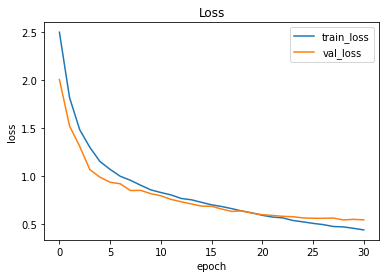

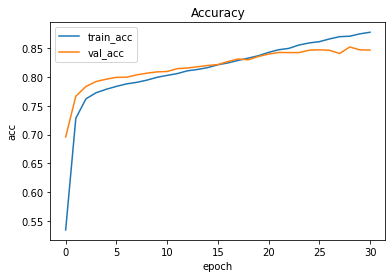

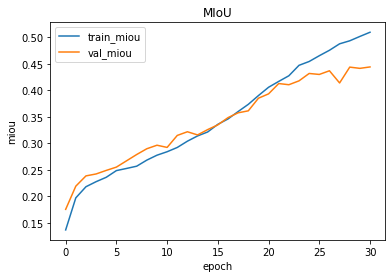

In [11]:
history = {'train_loss': train_loss_list, 'val_loss':val_loss_list,'train_miou': train_iou_list,
'val_miou':val_iou_list,'train_acc':train_acc_list,'val_acc':val_acc_list,'lr':lrs}
def plot_loss(history):
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

def plot_miou(history):
    plt.plot(history['train_miou'], label='train_miou')
    plt.plot(history['val_miou'], label='val_miou')
    plt.title('MIoU')
    plt.xlabel('epoch')
    plt.ylabel('miou')
    plt.legend()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_acc')
    plt.plot(history['val_acc'], label='val_acc')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.show()
plot_loss(history)
plot_acc(history)
plot_miou(history)

In [12]:
print(history['lr'])

[0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]


torch.Size([4, 3, 224, 224])
torch.Size([4, 21, 224, 224])
torch.Size([4, 224, 224])


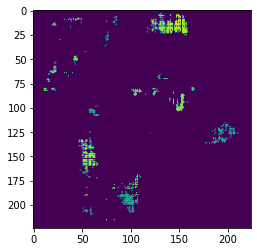

In [13]:
a, b= train_set[0]
FCN.eval()
with torch.no_grad():
    for i, data in enumerate(train_loader):
        a, b = data
        FCN.to(device)
        print(a.shape)
        a = a.to(device)
        c = FCN(a)
        break

print(c.shape)
mask = torch.argmax(c, dim=1)
print(mask.shape)
#print(c[0])
plt.imshow(mask[0].cpu())
# t = a.view(8,224,224,3)
# # t = t.view(224,224,3)
# plt.figure(figsize=(10,10))
# plt.subplot(1,3,1)
# plt.imshow(mask[0].cpu())
# plt.subplot(1,3,2)
# plt.imshow(b[0].cpu())
# plt.subplot(1,3,3)
# plt.imshow(t[0].cpu())
